In [1]:
# ==============================================================================
# CELL 0: Configuration & Imports
# ==============================================================================

import os
import json
import random
import pandas as pd
import sqlite3
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
    TrainerCallback
)
from sklearn.model_selection import train_test_split
from datetime import datetime
from itertools import combinations, product

# Configuration
CONFIG = {
    # File paths
    'csv_files': {
        "customer_purchases": "customer_purchases.csv",
        "customer_demographics": "customer_demographics.csv",
        "customer_satisfaction": "customer_satisfaction.csv",
        "customer_interests": "customer_interests.csv"
    },

    'db_path': "customer_data.db",
    'base_output_dir': "./sql_models",
    
    # Training config
    'model_name': "google/flan-t5-small",
    'initial_samples': 2000,
    'initial_epochs': 10,
    'initial_lr': 3e-4,
    'batch_size': 8,
    'max_input_length': 512,
    
    # Enhancement config
    'enhanced_data_path' : "sft_data/text_to_sql_enhanced.jsonl",
    'enhancement_samples_per_weak_type': 200,
    'output_v_1' : "./flan-t5-sql-model-v2",
    'weak_threshold': 85.0,
    'retrain_epochs': 10,
    'retrain_lr': 1e-4,
    
    # Data splits
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
}

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

os.makedirs(CONFIG['base_output_dir'], exist_ok=True)
os.makedirs("sft_data", exist_ok=True)

print("\n Configuration loaded!")


 Using device: cpu

 Configuration loaded!


In [2]:
# ==============================================================================
# CELL 1: SQL Query Templates (UNMODIFIED - Direct from your script)
# ==============================================================================

# Single-value aggregations (no grouping, uses {col})
SINGLE_AGG_TEMPLATES = {
    'AVG': (
        ["What is the overall average {col}?", "Calculate the average {col}.", "Find the mean {col}.",
         "Get the average {col}.", "What's the avg {col}?", "Show me the average {col}.",
         "Give me the average {col}.", "I need the average {col}.", "Tell me the average {col}.", "Display the mean {col}."],
        "SELECT AVG({col}) AS avg_{col_name} FROM {tables} WHERE {join_conditions};"
    ),
    'MAX': (
        ["What is the maximum {col}?", "Find the highest {col}.", "Get the largest {col}.", "Show the max {col}.",
         "What's the biggest {col}?", "Give me the maximum {col}.", "I need the highest {col}.",
         "Display the max {col}.", "Tell me the largest {col}.", "Show me the peak {col}."],
        "SELECT MAX({col}) AS max_{col_name} FROM {tables} WHERE {join_conditions};"
    ),
    'MIN': (
        ["What is the minimum {col}?", "Find the lowest {col}.", "Get the smallest {col}.", "Show the min {col}.",
         "What's the smallest {col}?", "Give me the minimum {col}.", "I need the lowest {col}.",
         "Display the min {col}.", "Tell me the smallest {col}.", "Show me the bottom {col}."],
        "SELECT MIN({col}) AS min_{col_name} FROM {tables} WHERE {join_conditions};"
    ),
    'SUM': (
        ["What is the total {col}?", "Calculate the sum of {col}.", "Find the total {col}.", "Get the sum of {col}.",
         "What's the total {col}?", "Sum up all {col}.", "Give me the total {col}.", "I need the sum of {col}.",
         "Add up all {col}.", "Show me the total {col}."],
        "SELECT SUM({col}) AS total_{col_name} FROM {tables} WHERE {join_conditions};"
    ),
    'COUNT': (
        ["How many {col} values are there?", "Count all {col}.", "What is the total count of {col}?",
         "How many entries of {col}?", "Give me the total number of {col}.", "How many {col} exist?",
         "Show me the count of {col}.", "I need the total count of {col}.", "What's the record count for {col}?",
         "Count all {col} values."],
        "SELECT COUNT({col}) AS count_{col_name} FROM {tables} WHERE {join_conditions};"
    ),
    'COUNT_DISTINCT': (
        ["How many unique {col} values are there?", "Count distinct {col}.", "Find unique {col} count.",
         "How many different {col}?", "What's the unique {col} count?", "Give me the number of distinct {col}.",
         "Show me unique {col} count.", "I need distinct {col} count.", "How many different values of {col}?",
         "Count the unique {col}."],
        "SELECT COUNT(DISTINCT {col}) AS unique_{col_name} FROM {tables} WHERE {join_conditions};"
    )
}

# Grouped aggregations
GROUPED_AGG_TEMPLATES = {
    'AVG': (
        ["Get the average {col} by {group_col}.", "What is the average {col} for each {group_col}?",
         "Show average {col} grouped by {group_col}.", "Find the mean {col} for each {group_col}.",
         "Calculate the average {col} for every {group_col}.", "What's the avg {col} per {group_col}?",
         "Show me the average {col} broken down by {group_col}.", "Display average {col} across different {group_col}.",
         "Give me average {col} by {group_col}.", "I want to see average {col} for each {group_col}."],
        "SELECT {group_col}, AVG({col}) AS avg_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    ),
    'MAX': (
        ["Get the maximum {col} by {group_col}.", "Show max {col} for each {group_col}.",
         "What is the highest {col} for each {group_col}?", "Find the largest {col} grouped by {group_col}.",
         "Report the max {col} per {group_col}.", "What's the biggest {col} by {group_col}?",
         "Show me the highest {col} for each {group_col}.", "Display maximum {col} across different {group_col}.",
         "I want the max {col} per {group_col}.", "Give me the largest {col} by {group_col}."],
        "SELECT {group_col}, MAX({col}) AS max_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    ),
    'MIN': (
        ["Get the minimum {col} by {group_col}.", "Show min {col} for each {group_col}.",
         "What is the lowest {col} for each {group_col}?", "Find the smallest {col} grouped by {group_col}.",
         "Report the min {col} per {group_col}.", "What's the smallest {col} by {group_col}?",
         "Show me the lowest {col} for each {group_col}.", "Display minimum {col} across different {group_col}.",
         "I want the min {col} per {group_col}.", "Give me the smallest {col} by {group_col}."],
        "SELECT {group_col}, MIN({col}) AS min_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    ),
    'SUM': (
        ["Get the total {col} by {group_col}.", "What is the sum of {col} for each {group_col}?",
         "Show total {col} grouped by {group_col}.", "Calculate the sum of {col} per {group_col}.",
         "What's the total {col} by {group_col}?", "Sum up {col} for each {group_col}.",
         "Give me total {col} per {group_col}.", "I want the sum of {col} grouped by {group_col}.",
         "Show me total {col} across different {group_col}.", "Add up {col} for each {group_col}."],
        "SELECT {group_col}, SUM({col}) AS total_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    ),
    'COUNT': (
        ["Count {col} by {group_col}.", "How many {col} for each {group_col}?",
         "Show count of {col} grouped by {group_col}.", "Give me the count of {col} per {group_col}.",
         "How many {col} are there by {group_col}?", "Count up {col} for each {group_col}.",
         "I want to count {col} grouped by {group_col}.", "Show me how many {col} per {group_col}.",
         "Display count of {col} across different {group_col}.", "Tell me the number of {col} by {group_col}."],
        "SELECT {group_col}, COUNT({col}) AS count_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    ),
    'COUNT_DISTINCT': (
        ["Count all distinct {col} by {group_col}.", "Show unique {col} count for each {group_col}.",
         "How many unique {col} values exist per {group_col}?", "Find the number of distinct {col} for each {group_col}.",
         "Report unique {col} per {group_col}.", "How many different {col} are there by {group_col}?",
         "Give me unique {col} count per {group_col}.", "Show me distinct {col} count for each {group_col}.",
         "I want to count unique {col} grouped by {group_col}.", "Display number of different {col} by {group_col}."],
        "SELECT {group_col}, COUNT(DISTINCT {col}) AS unique_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col};"
    )
}

# Table count templates
TABLE_COUNT_TEMPLATES = [
    "How many {table_name} rows are there?",
    "Count all {table_name} records.",
    "What is the total {table_name} count?",
    "How many {table_name} entries?",
    "Give me the total number of {table_name} records.",
    "How many {table_name} are there?",
    "Show me the {table_name} count.",
    "I need the total {table_name} count.",
    "What's the {table_name} record count?",
    "Count all {table_name}."
]

FILTER_TEMPLATES = [
    (["Show all rows where {col} = '{val}'.", "List records with {col} equal to '{val}'.",
      "Find all entries where {col} is '{val}'.", "Get rows where {col} equals '{val}'.",
      "Display records with {col} = '{val}'.", "I want rows where {col} is '{val}'.",
      "Show me where {col} = '{val}'.", "Give me records where {col} equals '{val}'.",
      "Find entries with {col} = '{val}'.", "Filter by {col} = '{val}'."],
     "SELECT * FROM {tables} WHERE {col} = '{val}' AND {join_conditions};"),
    
    (["Show all rows where {col} > {val}.", "Find records where {col} is greater than {val}.",
      "List entries with {col} larger than {val}.", "Get rows where {col} exceeds {val}.",
      "Display records with {col} > {val}.", "I want rows where {col} is more than {val}.",
      "Show me where {col} > {val}.", "Give me records where {col} is above {val}.",
      "Find entries with {col} greater than {val}.", "Filter by {col} > {val}."],
     "SELECT * FROM {tables} WHERE {col} GREATER_THAN {val} AND {join_conditions};"),
    
    (["Show all rows where {col} < {val}.", "Find records where {col} is less than {val}.",
      "List entries with {col} smaller than {val}.", "Get rows where {col} is below {val}.",
      "Display records with {col} < {val}.", "I want rows where {col} is less than {val}.",
      "Show me where {col} < {val}.", "Give me records where {col} is under {val}.",
      "Find entries with {col} less than {val}.", "Filter by {col} < {val}."],
     "SELECT * FROM {tables} WHERE {col} LESS_THAN {val} AND {join_conditions};"),
    
    (["Show all unique values of {col}.", "List distinct {col} values.", "Find all unique entries for {col}.",
      "Get unique {col}.", "Display distinct {col}.", "I want all different {col} values.",
      "Show me unique {col}.", "Give me distinct {col}.", "What are the different {col} values?",
      "List all unique {col}."],
     "SELECT DISTINCT {col} FROM {tables} WHERE {join_conditions};"),
]

# CASE WHEN templates
CASE_WHEN_TEMPLATES = [
    (["Show all customers and flag if their {col} is above {threshold}.",
      "List customers with a flag indicating if {col} exceeds {threshold}.",
      "Display customers and mark which ones have {col} greater than {threshold}.",
      "Show customers and identify those with high {col} (above {threshold}).",
      "Get all customers with an indicator for {col} above {threshold}."],
     "SELECT *, CASE WHEN {col} GREATER_THAN {threshold} THEN 'Yes' ELSE 'No' END AS high_{col_name}_flag FROM {tables} WHERE {join_conditions};"),
    
    (["Calculate a discount where customers get 10% off if {col} is above {threshold}, otherwise 5%.",
      "Show {col} with discount: 10% for values above {threshold}, 5% otherwise.",
      "Apply tiered discount based on {col}: 10% if over {threshold}, else 5%.",
      "Determine discount rate: 10% when {col} exceeds {threshold}, 5% when lower.",
      "Show customers with discount percentage based on their {col} level."],
     "SELECT *, {col}, CASE WHEN {col} GREATER_THAN {threshold} THEN 0.10 ELSE 0.05 END AS discount_rate FROM {tables} WHERE {join_conditions};"),
    
    (["Assign priority level: High if {col} is above {high_val}, Low if below {low_val}, otherwise Medium.",
      "Show customers with priority based on {col}: High (>{high_val}), Medium, or Low (<{low_val}).",
      "Calculate risk score: High for {col} over {high_val}, Low under {low_val}, Medium otherwise.",
      "Classify customers by {col}: High priority if above {high_val}, Low if under {low_val}.",
      "Determine urgency level based on {col} thresholds."],
     "SELECT *, CASE WHEN {col} GREATER_THAN {high_val} THEN 'High' WHEN {col} LESS_THAN {low_val} THEN 'Low' ELSE 'Medium' END AS priority_level FROM {tables} WHERE {join_conditions};"),
    
    (["Calculate adjusted {col} where values below {threshold} are doubled.",
      "Show {col} adjusted: if under {threshold} multiply by 2, otherwise keep same.",
      "Apply correction to {col}: double it when less than {threshold}.",
      "Compute modified {col} with boost for values under {threshold}.",
      "Show {col} with adjustment factor applied to low values."],
     "SELECT *, {col}, CASE WHEN {col} LESS_THAN {threshold} THEN {col} * 2 ELSE {col} END AS adjusted_{col_name} FROM {tables} WHERE {join_conditions};"),
    
    (["Show which customers are eligible for rewards (those with {col} >= {threshold}).",
      "Determine eligibility: qualified if {col} is {threshold} or higher.",
      "Flag customers as eligible when their {col} meets minimum of {threshold}.",
      "Show approval status based on {col} threshold of {threshold}.",
      "Identify which customers qualify based on {col} requirements."],
     "SELECT *, CASE WHEN {col} GREATER_EQUAL {threshold} THEN 'Eligible' ELSE 'Not Eligible' END AS rewards_status FROM {tables} WHERE {join_conditions};"),
]

# CTE templates
CTE_TEMPLATES = [
    (["Show each customer's {col} compared to the overall average.",
      "List customers with their {col} and how it compares to the average {col}.",
      "Display {col} for each customer alongside the average across all customers.",
      "Show customers and indicate if their {col} is above or below average.",
      "Compare each customer's {col} to the mean {col}."],
     "WITH avg_calc AS (SELECT AVG({col}) AS avg_{col_name} FROM {tables} WHERE {join_conditions}) SELECT t.*, a.avg_{col_name}, CASE WHEN t.{col_name} GREATER_THAN a.avg_{col_name} THEN 'Above Average' ELSE 'Below Average' END AS comparison FROM {tables} t CROSS JOIN avg_calc a WHERE {join_conditions};"),
    
    (["Show each customer's {col} along with the total {col} for their {group_col}.",
      "List customers with their {col} and the sum of {col} for their entire {group_col} group.",
      "Display individual {col} and the group total {col} by {group_col}.",
      "Show customers with their {col} and what percentage it is of their {group_col} total.",
      "Compare each customer's {col} to their {group_col} group total."],
     "WITH group_totals AS (SELECT {group_col}, SUM({col}) AS total_{col_name} FROM {tables} WHERE {join_conditions} GROUP BY {group_col}) SELECT t.*, g.total_{col_name} FROM {tables} t INNER JOIN group_totals g ON t.{group_col} = g.{group_col} WHERE {join_conditions};"),
    
    (["Show the average {col} for customers where {col2} is greater than {threshold}.",
      "Calculate mean {col} but only include customers with {col2} above {threshold}.",
      "Get average {col} for the subset of customers where {col2} exceeds {threshold}.",
      "Find the average {col} among high-{col2} customers (those over {threshold}).",
      "What's the mean {col} when filtered to {col2} GREATER_THAN {threshold}?"],
     "WITH filtered_customers AS (SELECT * FROM {tables} WHERE {col2} GREATER_THAN {threshold} AND {join_conditions}) SELECT AVG({col_name}) AS avg_{col_name} FROM filtered_customers;"),
    
    (["Show each customer's {col} and their rank within their {group_col} group.",
      "List customers with their {col} ranked by {group_col}.",
      "Display {col} with ranking within each {group_col}.",
      "Show where each customer stands in {col} compared to others in their {group_col}.",
      "Rank customers by {col} within each {group_col} category."],
     "WITH ranked_data AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY {group_col} ORDER BY {col} DESC) AS rank_num FROM {tables} WHERE {join_conditions}) SELECT * FROM ranked_data;"),
    
    (["Show customers whose {col} is in the top 25%.",
      "List only high performers with {col} in the upper quartile.",
      "Filter to customers with above-average {col}.",
      "Show top tier customers based on {col}.",
      "Get customers with the highest {col} values."],
     "WITH stats AS (SELECT AVG({col}) AS avg_{col_name} FROM {tables} WHERE {join_conditions}) SELECT t.* FROM {tables} t CROSS JOIN stats s WHERE t.{col} GREATER_EQUAL s.avg_{col_name} AND {join_conditions};"),
]

# Performer templates
PERFORMER_TEMPLATES = [
    (["Show customers whose {col} is in the top quartile.",
      "List only high performers with {col} in the upper quartile.",
      "Show customers in the top 25% quartile for {col}.",
      "Get customers in the upper quartile of {col}.",
      "Filter to customers with {col} in the top quartile range."],
     "WITH ranked AS (SELECT *, ROW_NUMBER() OVER (ORDER BY {col} DESC) AS row_num, COUNT(*) OVER () AS total_rows FROM {tables} WHERE {join_conditions}) SELECT * FROM ranked WHERE row_num LESS_EQUAL total_rows * 0.25;"),
    
    (["Show customers whose {col} is in the lower quartile.",
      "List customers with {col} values in the bottom quartile.",
      "Find users with {col} in the lowest 25% range.",
      "Show customers in the lowest quartile for {col}.",
      "Filter to bottom quartile performers by {col}."],
     "WITH ranked AS (SELECT *, ROW_NUMBER() OVER (ORDER BY {col} ASC) AS row_num, COUNT(*) OVER () AS total_rows FROM {tables} WHERE {join_conditions}) SELECT * FROM ranked WHERE row_num LESS_EQUAL total_rows * 0.25;"),
    
    (["Show customers in the top {percent}% for {col}.",
      "List users whose {col} is in the top {percent} percent.",
      "Filter to top {percent}% performers by {col}.",
      "Show the top {percent}% of {col} values.",
      "Give me customers with {col} in the upper {percent}%."],
     "WITH ranked AS (SELECT *, ROW_NUMBER() OVER (ORDER BY {col} DESC) AS row_num, COUNT(*) OVER () AS total_rows FROM {tables} WHERE {join_conditions}) SELECT * FROM ranked WHERE row_num LESS_EQUAL total_rows * ({percent} / 100.0);"),
    
    (["Show customers in the bottom {percent}% for {col}.",
      "List users with {col} in the lowest {percent} percent.",
      "Filter to the bottom {percent}% of performers by {col}.",
      "Get the bottom {percent}% of {col} values.",
      "Show customers whose {col} is in the lower {percent}%."],
     "WITH ranked AS (SELECT *, ROW_NUMBER() OVER (ORDER BY {col} ASC) AS row_num, COUNT(*) OVER () AS total_rows FROM {tables} WHERE {join_conditions}) SELECT * FROM ranked WHERE row_num LESS_EQUAL total_rows * ({percent} / 100.0);"),
]

print("Templates loaded!")


Templates loaded!


In [3]:
# ==============================================================================
# CELL 2: Helper Functions (UNMODIFIED from your script)
# ==============================================================================

def get_display_name(col_name):
    """Convert column name to human-readable format"""
    return col_name.replace('_', ' ').replace('dem ', '').replace('int ', '')

def get_display_name_random(col_name):
    """Get display name with random alias if available"""
    import random
    return random.choice([col_name] + COLUMN_ALIASES.get(col_name, []))
    
def determine_required_tables(columns, columns_per_table):
    """Determine which tables are needed for given columns"""
    tables = set()
    for col in columns:
        table_name = col.split('.')[0]
        tables.add(table_name)
    return list(tables)

def build_smart_join(tables):
    """Build JOIN clause for given tables - only join if multiple tables needed"""
    if len(tables) == 1:
        return tables[0], "1=1"
    
    # Multiple tables - use INNER JOIN with customer_id as join key
    tables_str = tables[0]
    for i in range(1, len(tables)):
        tables_str += f" INNER JOIN {tables[i]} ON {tables[0]}.customer_id = {tables[i]}.customer_id"
    
    return tables_str, "1=1"

def is_sql_valid(sql):
    """Simplified validation allowing CTEs and single-table joins"""
    import re
    try:
        sql = sql.strip()
        if not sql or sql.count('(') != sql.count(')'):
            return False
        
        # Look for FROM clause anywhere in the query (including inside CTEs)
        if not re.search(r'\bFROM\b\s+\w+', sql, re.IGNORECASE):
            return False
        
        # Basic check: must include SELECT and FROM
        if "SELECT" not in sql.upper() or "FROM" not in sql.upper():
            return False

        # Ensure WHERE is not malformed (if present)
        if "WHERE" in sql.upper():
            where_part = sql.split("WHERE")[1].split(";")[0]
            if not any(op in where_part for op in ['=', '>', '<', 'IN', 'LIKE', 'AND', 'OR']):
                return False
        
        return True
    except Exception:
        return False

def encode_sql_for_training(sql):
    """Encode SQL operators that conflict with tokenizer special tokens"""
    sql = sql.replace('<=', ' LESS_EQUAL ')
    sql = sql.replace('>=', ' GREATER_EQUAL ')
    sql = sql.replace('<', ' LESS_THAN ')
    sql = sql.replace('>', ' GREATER_THAN ')
    return ' '.join(sql.split())

def decode_sql_from_model(sql):
    """Decode SQL operators back from training format"""
    sql = sql.replace('LESS_EQUAL', '<=')
    sql = sql.replace('GREATER_EQUAL', '>=')
    sql = sql.replace('LESS_THAN', '<')
    sql = sql.replace('GREATER_THAN', '>')
    return sql

print("Helper functions loaded!")


Helper functions loaded!


In [4]:
# ==============================================================================
# CELL 3: Load Data and Setup Database
# ==============================================================================

print("="*80)
print("LOADING DATA")
print("="*80)

# Load CSVs
columns_per_table = {}
table_data = {}

for table, path in CONFIG['csv_files'].items():
    if not os.path.exists(path):
        print(f" WARNING: {path} not found - skipping {table}")
        continue
    
    df = pd.read_csv(path)
    table_data[table] = df
    columns_per_table[table] = {
        col: "text" if df[col].dtype == object else "int" if df[col].dtype == int else "float"
        for col in df.columns
    }
    print(f" Loaded {table}: {len(df)} rows, {len(df.columns)} columns")

# Create SQLite database
print(f"\nCreating database: {CONFIG['db_path']}...")
conn = sqlite3.connect(CONFIG['db_path'])

for table, df in table_data.items():
    df.to_sql(table, conn, if_exists="replace", index=False)
    print(f" Created table: {table}")

conn.close()

print("\n Data loaded and database created!")


LOADING DATA
 Loaded customer_purchases: 6365 rows, 5 columns
 Loaded customer_demographics: 5000 rows, 8 columns
 Loaded customer_satisfaction: 5000 rows, 8 columns
 Loaded customer_interests: 5000 rows, 25 columns

Creating database: customer_data.db...
 Created table: customer_purchases
 Created table: customer_demographics
 Created table: customer_satisfaction
 Created table: customer_interests

 Data loaded and database created!


In [5]:
# ==============================================================================
# CELL 4: Generate Initial Training Data (UNMODIFIED from your script)
# Run this cell to generate the base training dataset
# ==============================================================================

# NOTE: The complete generate_comprehensive_training_data function from your
# script should be inserted here. Due to length, I'm providing a wrapper that
# imports it from your original file or you can paste the entire function here.

# OPTION 1: Import from your original script
# from NL_SQL_Prompt_Generations import generate_comprehensive_training_data

# OPTION 2: Paste the entire function here (recommended)
# Copy the generate_comprehensive_training_data() function from your document
# starting from line "def generate_comprehensive_training_data..." to the end

# For now, assuming the function is available:
print("="*80)
print("GENERATING INITIAL TRAINING DATA")
print("="*80)

# Your complete unmodified generation function would go here
# I'll reference it exists for now
# dataset = generate_comprehensive_training_data(columns_per_table, table_data, CONFIG['initial_samples'])

# Placeholder - replace with your actual function call
# For now, load if file exists or generate
data_file = "sft_data/text_to_sql_sampled_balanced.jsonl"

if os.path.exists(data_file):
    print(f"Loading existing data from {data_file}...")
    with open(data_file, 'r') as f:
        dataset = [json.loads(line) for line in f]
    print(f" Loaded {len(dataset)} samples")
else:
    print(f" {data_file} not found. Please run your data generation script first.")
    dataset = []

    def generate_comprehensive_training_data(columns_per_table, table_data, target_samples):
        """
        Generate comprehensive SQL training examples with smart, relevant joins
        """
        import random
        data = []
        table_names = list(columns_per_table.keys())
        
        print(f"Template types defined:")
        print(f"  Single aggregations: {len(SINGLE_AGG_TEMPLATES)}")
        print(f"  Grouped aggregations: {len(GROUPED_AGG_TEMPLATES)}")
        
        # Get all columns with their table info - INCLUDING customer_id this time
        all_columns_info = {}
        for table, cols in columns_per_table.items():
            for col, col_type in cols.items():
                # CRITICAL FIX: Include customer_id columns in all_columns_info
                qualified_col = f"{table}.{col}"
                all_columns_info[qualified_col] = {
                    'table': table,
                    'name': col,
                    'type': col_type
                }
        
        # For aggregations, exclude customer_id
        numeric_cols = [k for k, v in all_columns_info.items() if v['type'] in ['int', 'float'] and v['name'] != 'customer_id']
        text_cols = [k for k, v in all_columns_info.items() if v['type'] == 'text']
        all_cols = numeric_cols + text_cols
        
        print(f"Total columns available: {len(all_cols)}")
        print(f"  Numeric: {len(numeric_cols)}")
        print(f"  Text: {len(text_cols)}")
        
        # FIXED: Define proportional targets for each section
        section_targets = {
            'single_agg': int(target_samples * 0.12),      # 12%
            'count': int(target_samples * 0.05),            # 5%
            'grouped_agg': int(target_samples * 0.30),      # 30%
            'single_filter': int(target_samples * 0.15),    # 15%
            'multi_filter': int(target_samples * 0.15),     # 15%
            'case_when': int(target_samples * 0.08),        # 8%
            'cte': int(target_samples * 0.10),              # 10%
            'performer': int(target_samples * 0.05)         # 5%
        }
        
        print(f"\nTarget distribution (total: {sum(section_targets.values())}):")
        for section, target in section_targets.items():
            print(f"  {section}: {target}")
        
        # --- 1. SINGLE-VALUE AGGREGATIONS (no grouping) ---
        print("\n1. Generating single-value aggregations...")
        section_start = len(data)
        target = section_targets['single_agg']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            col = random.choice(numeric_cols)
            col_info = all_columns_info[col]
            required_tables = [col_info['table']]
            tables_str, join_conditions = build_smart_join(required_tables)
            
            # Randomly pick one aggregation type
            agg_type = random.choice(list(SINGLE_AGG_TEMPLATES.keys()))
            q_templates, sql_template = SINGLE_AGG_TEMPLATES[agg_type]
            
            col_display = get_display_name(col_info['name'])
            col_name_clean = col_info['name'].replace('.', '_')
            
            question = random.choice(q_templates).format(col=col_display)
            sql = sql_template.format(col=col, tables=tables_str, join_conditions=join_conditions, col_name=col_name_clean)
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} single-value queries (target: {target})")
        
        # --- 2. COUNT QUERIES (table references) ---
        print("\n2. Generating COUNT queries (table references)...")
        section_start = len(data)
        target = section_targets['count']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            table = random.choice(table_names)
            tables_str = table
            join_conditions = "1=1"
            table_display = table.replace('_', ' ')
            
            question = random.choice(TABLE_COUNT_TEMPLATES).format(table_name=table_display)
            sql = f"SELECT COUNT(*) AS total_count FROM {tables_str} WHERE {join_conditions};"
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} COUNT queries (target: {target})")
        
        # --- 3. GROUPED AGGREGATIONS (FIXED) ---
        print("\n3. Generating grouped aggregations...")
        section_start = len(data)
        target = section_targets['grouped_agg']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            numeric_col = random.choice(numeric_cols)
            num_info = all_columns_info[numeric_col]
            
            # Build proper list of grouping columns
            possible_groups = []
            customer_id_col = f"{num_info['table']}.customer_id"
            possible_groups.append(customer_id_col)
            
            same_table_text_cols = [c for c in text_cols if all_columns_info[c]['table'] == num_info['table']]
            possible_groups.extend(same_table_text_cols)
            
            for text_col in text_cols:
                text_info = all_columns_info[text_col]
                if text_col not in possible_groups:
                    if 'customer_id' in columns_per_table[num_info['table']] and \
                       'customer_id' in columns_per_table[text_info['table']]:
                        possible_groups.append(text_col)
            
            if len(possible_groups) == 0:
                continue
            
            group_col = random.choice(possible_groups)
            
            # Determine required tables for this combination
            required_tables = determine_required_tables([numeric_col, group_col], columns_per_table)
            tables_str, join_conditions = build_smart_join(required_tables)
            
            # VALIDATION: Ensure the numeric column's table is in the query
            num_table = all_columns_info[numeric_col]['table']
            if num_table not in tables_str:
                continue
            
            # Randomly pick one aggregation type
            agg_type = random.choice(list(GROUPED_AGG_TEMPLATES.keys()))
            q_templates, sql_template = GROUPED_AGG_TEMPLATES[agg_type]
            
            col_display = get_display_name(numeric_col.split('.')[-1])
            group_display = get_display_name(group_col.split('.')[-1])
            col_name_clean = numeric_col.split('.')[-1]
            
            question = random.choice(q_templates).format(col=col_display, group_col=group_display)
            sql = sql_template.format(
                col=numeric_col,
                group_col=group_col,
                tables=tables_str, 
                join_conditions=join_conditions, 
                col_name=col_name_clean
            )
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} grouped aggregation queries (target: {target})")
        
        # --- 4. SINGLE-COLUMN FILTERS ---
        print("\n4. Generating single-column filters...")
        section_start = len(data)
        target = section_targets['single_filter']
        attempts = 0
        max_attempts = target * 3
        skipped_count = 0
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            col = random.choice(all_cols)
            col_info = all_columns_info[col]
            required_tables = [col_info['table']]
            tables_str, join_conditions = build_smart_join(required_tables)
            
            unique_vals = table_data[col_info['table']][col_info['name']].dropna().unique()
            if len(unique_vals) == 0:
                continue
            
            val = random.choice(unique_vals)
            col_display = get_display_name(col_info['name'])
            
            # Choose appropriate template based on column type
            if col_info['type'] in ['int', 'float']:
                q_templates, sql_template = random.choice(FILTER_TEMPLATES)
            else:
                # Text columns: only use equality or DISTINCT
                valid_templates = [FILTER_TEMPLATES[0], FILTER_TEMPLATES[3]]
                q_templates, sql_template = random.choice(valid_templates)
            
            # Handle different template types
            if '{val}' in q_templates[0]:
                question = random.choice(q_templates).format(col=col_display, val=val)
                sql = sql_template.format(col=col, val=val, tables=tables_str, join_conditions=join_conditions)
            else:
                question = random.choice(q_templates).format(col=col_display)
                sql = sql_template.format(col=col, tables=tables_str, join_conditions=join_conditions)
            
            # VALIDATION
            if "WHERE" in sql:
                where_part = sql.split("WHERE")[1].split("GROUP BY")[0].split("ORDER BY")[0].split(";")[0]
                if where_part.strip() not in ["1=1", "1=1 AND"]:
                    if not any(op in where_part for op in ['=', '>', '<', '>=', '<=', '!=', 'IN', 'LIKE', 'BETWEEN', 'GREATER', 'LESS']):
                        skipped_count += 1
                        continue
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} single-column filter queries (target: {target}, skipped: {skipped_count})")
        
        # --- 5. MULTI-COLUMN FILTERS ---
        print("\n5. Generating multi-column filters...")
        section_start = len(data)
        target = section_targets['multi_filter']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            n = random.choice([2, 3])
            selected_cols = random.sample(all_cols, min(n, len(all_cols)))
            
            required_tables = determine_required_tables(selected_cols, columns_per_table)
            tables_str, join_conditions = build_smart_join(required_tables)
            
            vals, col_display_names = [], []
            skip = False
            
            for col in selected_cols:
                col_info = all_columns_info[col]
                unique_vals = table_data[col_info['table']][col_info['name']].dropna().unique()
                
                if len(unique_vals) == 0:
                    skip = True
                    break
                
                col_display_names.append(get_display_name(col_info['name']))
                vals.append(random.choice(unique_vals))
            
            if skip:
                continue
            
            if random.random() < 0.5:
                col_list = ", ".join(selected_cols)
                nl = "Show " + ", ".join(col_display_names) + " where " + " AND ".join([f"{c} = '{v}'" for c, v in zip(col_display_names, vals)]) + "."
                sql = f"SELECT {col_list} FROM {tables_str} WHERE " + " AND ".join([f"{c} = '{v}'" for c, v in zip(selected_cols, vals)])
            else:
                nl = "Show all rows where " + " AND ".join([f"{c} = '{v}'" for c, v in zip(col_display_names, vals)]) + "."
                sql = f"SELECT * FROM {tables_str} WHERE " + " AND ".join([f"{c} = '{v}'" for c, v in zip(selected_cols, vals)])
            
            if join_conditions != "1=1":
                sql += f" AND {join_conditions}"
            sql += ";"
            
            if is_sql_valid(sql):
                data.append({"instruction": nl, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} multi-column filter queries (target: {target})")
        
        # --- 6. CASE WHEN QUERIES ---
        print("\n6. Generating CASE WHEN queries...")
        section_start = len(data)
        target = section_targets['case_when']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            col = random.choice(numeric_cols)
            col_info = all_columns_info[col]
            required_tables = [col_info['table']]
            tables_str, join_conditions = build_smart_join(required_tables)
            
            col_display = get_display_name(col_info['name'])
            col_name_clean = col_info['name'].replace('.', '_')
            
            col_values = table_data[col_info['table']][col_info['name']].dropna()
            if len(col_values) == 0:
                continue
            
            template_idx = random.randint(0, len(CASE_WHEN_TEMPLATES) - 1)
            q_templates, sql_template = CASE_WHEN_TEMPLATES[template_idx]
            
            if template_idx in [0, 1, 3, 4]:
                threshold = col_values.median()
                question = random.choice(q_templates).format(col=col_display, threshold=threshold)
                sql = sql_template.format(col=col, threshold=threshold, 
                                        col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
            else:
                low_val = col_values.quantile(0.33)
                high_val = col_values.quantile(0.67)
                question = random.choice(q_templates).format(col=col_display, low_val=low_val, high_val=high_val)
                sql = sql_template.format(col=col, low_val=low_val, high_val=high_val, 
                                        col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} CASE WHEN queries (target: {target})")
        
        # --- 7. CTE QUERIES ---
        print("\n7. Generating CTE queries...")
        section_start = len(data)
        target = section_targets['cte']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            if len(text_cols) == 0:
                break
                
            col = random.choice(numeric_cols)
            col_info = all_columns_info[col]
            col_display = get_display_name(col_info['name'])
            col_name_clean = col_info['name'].replace('.', '_')
            
            template_idx = random.randint(0, len(CTE_TEMPLATES) - 1)
            q_templates, sql_template = CTE_TEMPLATES[template_idx]
            
            if template_idx == 0:
                required_tables = [col_info['table']]
                tables_str, join_conditions = build_smart_join(required_tables)
                
                question = random.choice(q_templates).format(col=col_display)
                sql = sql_template.format(col=col, col_name=col_name_clean,
                                        tables=tables_str, join_conditions=join_conditions)
            
            elif template_idx == 1:
                possible_group_cols = []
                same_table_text = [c for c in text_cols if all_columns_info[c]['table'] == col_info['table']]
                possible_group_cols.extend(same_table_text)
                
                if len(possible_group_cols) == 0:
                    possible_group_cols.append(f"{col_info['table']}.customer_id")
                
                group_col = random.choice(possible_group_cols)
                group_display = get_display_name(group_col.split('.')[-1])
                
                required_tables = determine_required_tables([col, group_col], columns_per_table)
                tables_str, join_conditions = build_smart_join(required_tables)
                
                question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                sql = sql_template.format(col=col, group_col=group_col, col_name=col_name_clean,
                                        tables=tables_str, join_conditions=join_conditions)
            
            elif template_idx == 2:
                same_table_numeric = [c for c in numeric_cols if all_columns_info[c]['table'] == col_info['table'] and c != col]
                
                if len(same_table_numeric) == 0:
                    continue
                
                col2 = random.choice(same_table_numeric)
                col2_info = all_columns_info[col2]
                col2_display = get_display_name(col2_info['name'])
                
                required_tables = determine_required_tables([col, col2], columns_per_table)
                tables_str, join_conditions = build_smart_join(required_tables)
                
                col2_values = table_data[col2_info['table']][col2_info['name']].dropna()
                if len(col2_values) == 0:
                    continue
                threshold = col2_values.median()
                
                question = random.choice(q_templates).format(col=col_display, col2=col2_display, threshold=threshold)
                sql = sql_template.format(
                    col=col,
                    col2=col2,
                    col_name=col_info['name'],
                    threshold=threshold, 
                    tables=tables_str, 
                    join_conditions=join_conditions
                )
            
            elif template_idx == 3:
                possible_group_cols = []
                same_table_text = [c for c in text_cols if all_columns_info[c]['table'] == col_info['table']]
                possible_group_cols.extend(same_table_text)
                
                if len(possible_group_cols) == 0:
                    possible_group_cols.append(f"{col_info['table']}.customer_id")
                
                group_col = random.choice(possible_group_cols)
                group_display = get_display_name(group_col.split('.')[-1])
                
                required_tables = determine_required_tables([col, group_col], columns_per_table)
                tables_str, join_conditions = build_smart_join(required_tables)
                
                question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                sql = sql_template.format(col=col, group_col=group_col,
                                        tables=tables_str, join_conditions=join_conditions)
            
            else:
                required_tables = [col_info['table']]
                tables_str, join_conditions = build_smart_join(required_tables)
                
                question = random.choice(q_templates).format(col=col_display)
                sql = sql_template.format(col=col, col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} CTE queries (target: {target})")
        
        # --- 8. PERFORMER QUERIES (Quartile/Percentile) ---
        print("\n8. Generating PERFORMER queries...")
        section_start = len(data)
        target = section_targets['performer']
        attempts = 0
        max_attempts = target * 3
        
        while len(data) - section_start < target and attempts < max_attempts:
            attempts += 1
            col = random.choice(numeric_cols)
            col_info = all_columns_info[col]
            col_display = get_display_name(col_info['name'])
            
            required_tables = [col_info['table']]
            tables_str, join_conditions = build_smart_join(required_tables)
            
            template_idx = random.randint(0, len(PERFORMER_TEMPLATES) - 1)
            q_templates, sql_template = PERFORMER_TEMPLATES[template_idx]
            
            if template_idx in [0, 1]:
                question = random.choice(q_templates).format(col=col_display)
                sql = sql_template.format(col=col, tables=tables_str, join_conditions=join_conditions)
            else:
                percent = random.choice([5, 10, 15, 20, 30, 40, 50])
                question = random.choice(q_templates).format(col=col_display, percent=percent)
                sql = sql_template.format(col=col, percent=percent, tables=tables_str, join_conditions=join_conditions)
            
            if is_sql_valid(sql):
                data.append({"instruction": question, "input": "", "output": sql})
        
        print(f"  Generated {len(data) - section_start} PERFORMER queries (target: {target})")
        
        print(f"\n Total generated: {len(data)} samples (target was {target_samples})")
        
        # NO TRUNCATION - just return what was generated
        return data

    # Generate and save
    import json
    dataset = generate_comprehensive_training_data(columns_per_table, table_data, target_samples=CONFIG[ 'initial_samples'])
    print(f"\n Generated {len(dataset)} valid training examples")
    
    output_path = "sft_data/text_to_sql_sampled_balanced.jsonl"
    with open(output_path, "w", encoding="utf-8") as f:
        for record in dataset:
            f.write(json.dumps(record) + "\n")
    
    print(f"Saved JSONL dataset to {output_path}")
    conn.close()
    # Then encode and save:
    for record in dataset:
        record['output'] = encode_sql_for_training(record['output'])
    # 
    with open(data_file, 'w') as f:
        for record in dataset:
            f.write(json.dumps(record) + '\n')

GENERATING INITIAL TRAINING DATA
 sft_data/text_to_sql_sampled_balanced.jsonl not found. Please run your data generation script first.
Template types defined:
  Single aggregations: 6
  Grouped aggregations: 6
Total columns available: 42
  Numeric: 38
  Text: 4

Target distribution (total: 2000):
  single_agg: 240
  count: 100
  grouped_agg: 600
  single_filter: 300
  multi_filter: 300
  case_when: 160
  cte: 200
  performer: 100

1. Generating single-value aggregations...
  Generated 240 single-value queries (target: 240)

2. Generating COUNT queries (table references)...
  Generated 100 COUNT queries (target: 100)

3. Generating grouped aggregations...
  Generated 600 grouped aggregation queries (target: 600)

4. Generating single-column filters...
  Generated 300 single-column filter queries (target: 300, skipped: 0)

5. Generating multi-column filters...
  Generated 300 multi-column filter queries (target: 300)

6. Generating CASE WHEN queries...
  Generated 160 CASE WHEN queries (

In [6]:
# ==============================================================================
# CELL 5: Prepare Data for Training
# ==============================================================================

print("="*80)
print("PREPARING TRAINING DATA")
print("="*80)

# Load data
if len(dataset) == 0:
    with open("sft_data/text_to_sql_sampled_balanced.jsonl", 'r') as f:
        dataset = [json.loads(line) for line in f]

print(f"Total samples: {len(dataset)}")

# Shuffle
random.seed(42)
random.shuffle(dataset)

# Split data
train_size = int(len(dataset) * CONFIG['train_split'])
val_size = int(len(dataset) * CONFIG['val_split'])

train_data = dataset[:train_size]
val_data = dataset[train_size:train_size + val_size]
test_data = dataset[train_size + val_size:]

print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Test: {len(test_data)}")

# Save test data for later evaluation
with open("sft_data/test_data.jsonl", 'w') as f:
    for record in test_data:
        f.write(json.dumps(record) + '\n')

print("Data prepared!")

PREPARING TRAINING DATA
Total samples: 2000
Train: 1600
Val: 200
Test: 200
Data prepared!


In [7]:
# ==============================================================================
# CELL 6: Initialize Model and Tokenizer
# ==============================================================================

print("="*80)
print("INITIALIZING MODEL")
print("="*80)

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
model = AutoModelForSeq2SeqLM.from_pretrained(CONFIG['model_name'])
model.to(device)

print(f"Model loaded: {CONFIG['model_name']}")

# Analyze SQL lengths
sql_lengths = [len(tokenizer.encode(item["output"])) for item in train_data]
percentile_99 = sorted(sql_lengths)[int(len(sql_lengths) * 0.99)]
MAX_TARGET_LENGTH = min(percentile_99 + 20, 512)

print(f"Max target length: {MAX_TARGET_LENGTH}")

# Preprocessing function
def preprocess_function(examples):
    inputs = [f"Translate this to SQL: {instr} {inp}".strip() 
              for instr, inp in zip(examples["instruction"], examples["input"])]
    
    model_inputs = tokenizer(
        inputs, 
        max_length=CONFIG['max_input_length'], 
        truncation=True, 
        padding="max_length"
    )
    
    labels = tokenizer(
        examples["output"], 
        max_length=MAX_TARGET_LENGTH, 
        truncation=True, 
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def create_dataset(data_list):
    return Dataset.from_dict({
        "instruction": [d["instruction"] for d in data_list],
        "input": [d.get("input", "") for d in data_list],
        "output": [d["output"] for d in data_list]
    })

# Create datasets
print("\nTokenizing datasets...")
train_dataset = create_dataset(train_data).map(preprocess_function, batched=True)
val_dataset = create_dataset(val_data).map(preprocess_function, batched=True)
test_dataset = create_dataset(test_data).map(preprocess_function, batched=True)

print("Datasets prepared!")

INITIALIZING MODEL
Model loaded: google/flan-t5-small
Max target length: 181

Tokenizing datasets...


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Datasets prepared!


In [8]:
# ==============================================================================
# CELL 7: Train Initial Model
# ==============================================================================

print("="*80)
print("TRAINING INITIAL MODEL")
print("="*80)

## model path for first model.  second version will be output_dir_v1 = f"{CONFIG['base_output_dir']}/model_v1"
output_dir_v0 = f"{CONFIG['base_output_dir']}/model_v0"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir_v0,
    num_train_epochs=CONFIG['initial_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['initial_lr'],
    weight_decay=0.01,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    
    # Ensure we actually see the loss changing
    logging_strategy="epoch",
    logging_steps=1,
    logging_first_step=True,
    
    push_to_hub=False,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print(f"Training for {CONFIG['initial_epochs']} epochs...")
train_result = trainer.train()

# Save model
trainer.save_model(output_dir_v0)
tokenizer.save_pretrained(output_dir_v0)
print(f"Model saved to {output_dir_v0}")

TRAINING INITIAL MODEL
Training for 10 epochs...


C:\Users\User 1\AppData\Local\Temp\ipykernel_17972\941601719.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,1.407600,0.020321
2,0.033000,0.006698
3,0.014300,0.003027
4,0.008900,0.002408
5,0.005800,0.001663
6,0.004400,0.001383
7,0.003700,0.001379
8,0.003400,0.001250
9,0.002600,0.001275
10,0.002500,0.001141


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Model saved to ./sql_models/model_v0


In [9]:
# ==============================================================================
# CELL 8: Evaluate Initial Model
# ==============================================================================

print("="*80)
print("EVALUATING INITIAL MODEL")
print("="*80)

def categorize_query(sql):
    """Categorize SQL query by type and complexity"""
    sql_upper = sql.upper()
    categories = []
    
    # Main query types
    if 'WITH' in sql_upper:
        categories.append('CTE')
    if 'CASE WHEN' in sql_upper:
        categories.append('CASE_WHEN')
    if 'JOIN' in sql_upper:
        categories.append('JOIN')
    if 'GROUP BY' in sql_upper:
        categories.append('GROUP_BY')
    if 'ORDER BY' in sql_upper:
        categories.append('ORDER_BY')
    if 'ROW_NUMBER()' in sql_upper or 'PARTITION BY' in sql_upper:
        categories.append('WINDOW_FUNCTION')
    
    # Aggregation types
    if 'AVG(' in sql_upper:
        categories.append('AVG')
    if 'MAX(' in sql_upper:
        categories.append('MAX')
    if 'MIN(' in sql_upper:
        categories.append('MIN')
    if 'SUM(' in sql_upper:
        categories.append('SUM')
    if 'COUNT(' in sql_upper:
        categories.append('COUNT')
    
    # Operators
    if 'LESS_THAN' in sql or '<' in sql:
        categories.append('LESS_THAN_OP')
    if 'GREATER_THAN' in sql or '>' in sql:
        categories.append('GREATER_THAN_OP')
    if 'LESS_EQUAL' in sql or '<=' in sql:
        categories.append('LESS_EQUAL_OP')
    if 'GREATER_EQUAL' in sql or '>=' in sql:
        categories.append('GREATER_EQUAL_OP')
    
    # Simple queries
    if len(categories) == 0:
        if 'SELECT * FROM' in sql_upper and 'WHERE' in sql_upper:
            categories.append('SIMPLE_FILTER')
        elif 'SELECT DISTINCT' in sql_upper:
            categories.append('DISTINCT')
        elif 'SELECT COUNT(*)' in sql_upper:
            categories.append('SIMPLE_COUNT')
        else:
            categories.append('SIMPLE_SELECT')
    
    # Complexity level
    complexity = 'SIMPLE'
    if len(categories) >= 3:
        complexity = 'COMPLEX'
    elif len(categories) >= 2:
        complexity = 'MEDIUM'
    
    return categories, complexity


def execute_and_compare(predicted_sql, actual_sql, db_path):
    """Execute and compare SQL queries"""
    conn = sqlite3.connect(db_path)
    
    try:
        pred_result = pd.read_sql_query(predicted_sql, conn)
        pred_success = True
    except:
        pred_success = False
    
    try:
        actual_result = pd.read_sql_query(actual_sql, conn)
        actual_success = True
    except:
        actual_success = False
    
    conn.close()
    
    if pred_success and actual_success:
        if len(pred_result) == len(actual_result) and pred_result.equals(actual_result):
            return True
    return False

# Evaluate
results = []
print(f"Evaluating {len(test_dataset)} samples...")

for idx in range(len(test_dataset)):
    if idx % 50 == 0:
        print(f"  Progress: {idx}/{len(test_dataset)}")
    
    sample = test_dataset[idx]
    input_ids = torch.tensor([sample["input_ids"]]).to(device)
    
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=MAX_TARGET_LENGTH)
    
    predicted_sql = decode_sql_from_model(
        tokenizer.decode(outputs[0], skip_special_tokens=True)
    )
    actual_sql = decode_sql_from_model(
        tokenizer.decode(sample["labels"], skip_special_tokens=True)
    )
    
    categories, complexity = categorize_query(actual_sql)
    results_match = execute_and_compare(predicted_sql, actual_sql, CONFIG['db_path'])
    
    results.append({
        'categories': categories,
        'complexity': complexity,
        'results_match': results_match,
        'predicted_sql': predicted_sql,
        'actual_sql': actual_sql
    })

df_results = pd.DataFrame(results)

# Analysis
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)

overall_acc = 100 * df_results['results_match'].sum() / len(df_results)
print(f"\nOverall Accuracy: {overall_acc:.1f}%")

# By category
all_categories = set()
for cats in df_results['categories']:
    all_categories.update(cats)

category_stats = []
for cat in sorted(all_categories):
    subset = df_results[df_results['categories'].apply(lambda x: cat in x)]
    if len(subset) > 0:
        correct = subset['results_match'].sum()
        accuracy = 100 * correct / len(subset)
        category_stats.append({
            'category': cat,
            'total': len(subset),
            'correct': correct,
            'accuracy': accuracy
        })

df_cat_stats = pd.DataFrame(category_stats).sort_values('accuracy')
print("\nBy Category:")
print(df_cat_stats.to_string(index=False))

# Identify weak categories
weak_categories = df_cat_stats[df_cat_stats['accuracy'] < CONFIG['weak_threshold']]['category'].tolist()

if weak_categories:
    print(f"\n Weak categories (< {CONFIG['weak_threshold']}%):")
    for cat in weak_categories:
        row = df_cat_stats[df_cat_stats['category'] == cat].iloc[0]
        print(f"  {cat}: {row['accuracy']:.1f}% ({int(row['correct'])}/{int(row['total'])})")
else:
    print(f"\n All categories above {CONFIG['weak_threshold']}%!")

# Save results
df_results.to_csv(f"{output_dir_v0}/test_results.csv", index=False)
df_cat_stats.to_csv(f"{output_dir_v0}/category_stats.csv", index=False)

print(f"\n Evaluation complete!")

EVALUATING INITIAL MODEL
Evaluating 200 samples...
  Progress: 0/200
  Progress: 50/200
  Progress: 100/200
  Progress: 150/200

PERFORMANCE ANALYSIS

Overall Accuracy: 91.0%

By Category:
        category  total  correct   accuracy
GREATER_EQUAL_OP      7        3  42.857143
   LESS_EQUAL_OP     13        6  46.153846
        ORDER_BY     17       10  58.823529
 WINDOW_FUNCTION     17       10  58.823529
             CTE     31       19  61.290323
    LESS_THAN_OP     22       15  68.181818
             SUM     14       12  85.714286
 GREATER_THAN_OP     28       24  85.714286
           COUNT     51       44  86.274510
             AVG     25       22  88.000000
            JOIN     75       66  88.000000
   SIMPLE_FILTER     18       17  94.444444
       CASE_WHEN     19       18  94.736842
        GROUP_BY     58       56  96.551724
        DISTINCT      9        9 100.000000
             MAX     13       13 100.000000
   SIMPLE_SELECT      4        4 100.000000
             MIN   

In [10]:
def generate_targeted_training_data(columns_per_table, table_data, weak_categories, samples_per_category=500):
    """
    Generate targeted training data for weak query categories automatically.
    Uses templates already defined in global scope (SINGLE_AGG_TEMPLATES, etc.)
    
    Args:
        columns_per_table: Dict of table schemas
        table_data: Dict of dataframes
        weak_categories: List of weak category names like ['GREATER_EQUAL_OP', 'CTE', 'AVG']
        samples_per_category: Number of samples to generate per weak category
    
    Returns:
        List of training examples
    """
    import random
    data = []
    table_names = list(columns_per_table.keys())
    
    print(f"Generating targeted training data for weak query types...")
    print(f"Weak categories: {weak_categories}")
    print(f"Samples per category: {samples_per_category}\n")
    
    # Build column info (same as original)
    all_columns_info = {}
    for table, cols in columns_per_table.items():
        for col, col_type in cols.items():
            qualified_col = f"{table}.{col}"
            all_columns_info[qualified_col] = {
                'table': table,
                'name': col,
                'type': col_type
            }
    
    numeric_cols = [k for k, v in all_columns_info.items() if v['type'] in ['int', 'float'] and v['name'] != 'customer_id']
    text_cols = [k for k, v in all_columns_info.items() if v['type'] == 'text']
    all_cols = numeric_cols + text_cols
    
    # Generate for each weak category
    for category in weak_categories:
        print(f"\nGenerating {samples_per_category} {category} queries...")
        section_start = len(data)
        attempts = 0
        max_attempts = samples_per_category * 3
        
        # --- SINGLE AGGREGATIONS (AVG, MAX, MIN, SUM, COUNT) ---
        if category in SINGLE_AGG_TEMPLATES:
            q_templates, sql_template = SINGLE_AGG_TEMPLATES[category]
            
            while len(data) - section_start < samples_per_category and attempts < max_attempts:
                attempts += 1
                col = random.choice(numeric_cols)
                col_info = all_columns_info[col]
                required_tables = [col_info['table']]
                tables_str, join_conditions = build_smart_join(required_tables)
                
                col_display = get_display_name(col_info['name'])
                col_name_clean = col_info['name'].replace('.', '_')
                
                question = random.choice(q_templates).format(col=col_display)
                sql = sql_template.format(col=col, tables=tables_str, join_conditions=join_conditions, col_name=col_name_clean)
                
                if is_sql_valid(sql):
                    data.append({"instruction": question, "input": "", "output": sql})
        
        # --- GROUPED AGGREGATIONS WITH GROUP_BY ---
        elif category == 'GROUP_BY':
            # Generate various grouped aggregations
            for _ in range(samples_per_category):
                if attempts >= max_attempts:
                    break
                attempts += 1
                
                agg_type = random.choice(list(GROUPED_AGG_TEMPLATES.keys()))
                q_templates, sql_template = GROUPED_AGG_TEMPLATES[agg_type]
                
                numeric_col = random.choice(numeric_cols)
                num_info = all_columns_info[numeric_col]
                
                # Build grouping columns
                possible_groups = [f"{num_info['table']}.customer_id"]
                same_table_text_cols = [c for c in text_cols if all_columns_info[c]['table'] == num_info['table']]
                possible_groups.extend(same_table_text_cols)
                
                for text_col in text_cols:
                    text_info = all_columns_info[text_col]
                    if text_col not in possible_groups:
                        if 'customer_id' in columns_per_table[num_info['table']] and \
                           'customer_id' in columns_per_table[text_info['table']]:
                            possible_groups.append(text_col)
                
                if len(possible_groups) == 0:
                    continue
                
                group_col = random.choice(possible_groups)
                required_tables = determine_required_tables([numeric_col, group_col], columns_per_table)
                tables_str, join_conditions = build_smart_join(required_tables)
                
                if all_columns_info[numeric_col]['table'] not in tables_str:
                    continue
                
                col_display = get_display_name(numeric_col.split('.')[-1])
                group_display = get_display_name(group_col.split('.')[-1])
                col_name_clean = numeric_col.split('.')[-1]
                
                question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                sql = sql_template.format(
                    col=numeric_col,
                    group_col=group_col,
                    tables=tables_str,
                    join_conditions=join_conditions,
                    col_name=col_name_clean
                )
                
                if is_sql_valid(sql):
                    data.append({"instruction": question, "input": "", "output": sql})
        
        # --- COMPARISON OPERATORS ---
        elif category in ['GREATER_THAN_OP', 'LESS_THAN_OP', 'GREATER_EQUAL_OP', 'LESS_EQUAL_OP']:
            op_map = {
                'GREATER_THAN_OP': ('GREATER_THAN', 1),  # Index in FILTER_TEMPLATES
                'LESS_THAN_OP': ('LESS_THAN', 2),
                'GREATER_EQUAL_OP': ('GREATER_EQUAL', None),
                'LESS_EQUAL_OP': ('LESS_EQUAL', None)
            }
            
            sql_op, template_idx = op_map[category]
            
            # For GREATER_EQUAL and LESS_EQUAL, create custom templates
            if category == 'GREATER_EQUAL_OP':
                question_templates = [
                    "Show all rows where {col} is greater than or equal to {val}.",
                    "Find records where {col} is at least {val}.",
                    "List entries with {col} of {val} or higher.",
                    "Get rows where {col} meets or exceeds {val}.",
                    "Display records with {col} >= {val}.",
                ]
            elif category == 'LESS_EQUAL_OP':
                question_templates = [
                    "Show all rows where {col} is less than or equal to {val}.",
                    "Find records where {col} is at most {val}.",
                    "List entries with {col} of {val} or lower.",
                    "Get rows where {col} does not exceed {val}.",
                    "Display records with {col} <= {val}.",
                ]
            else:
                # Use existing FILTER_TEMPLATES
                question_templates, _ = FILTER_TEMPLATES[template_idx]
            
            while len(data) - section_start < samples_per_category and attempts < max_attempts:
                attempts += 1
                col = random.choice(numeric_cols)
                col_info = all_columns_info[col]
                col_values = table_data[col_info['table']][col_info['name']].dropna()
                
                if len(col_values) == 0:
                    continue
                
                val = col_values.quantile(random.choice([0.25, 0.5, 0.75]))
                col_display = get_display_name(col_info['name'])
                
                required_tables = [col_info['table']]
                tables_str, join_conditions = build_smart_join(required_tables)
                
                question = random.choice(question_templates).format(col=col_display, val=val)
                sql = f"SELECT * FROM {tables_str} WHERE {col} {sql_op} {val} AND {join_conditions};"
                
                if is_sql_valid(sql):
                    data.append({"instruction": question, "input": "", "output": sql})
        
        # --- CASE WHEN ---
        elif category == 'CASE_WHEN':
            while len(data) - section_start < samples_per_category and attempts < max_attempts:
                attempts += 1
                col = random.choice(numeric_cols)
                col_info = all_columns_info[col]
                required_tables = [col_info['table']]
                tables_str, join_conditions = build_smart_join(required_tables)
                
                col_display = get_display_name(col_info['name'])
                col_name_clean = col_info['name'].replace('.', '_')
                
                col_values = table_data[col_info['table']][col_info['name']].dropna()
                if len(col_values) == 0:
                    continue
                
                template_idx = random.randint(0, len(CASE_WHEN_TEMPLATES) - 1)
                q_templates, sql_template = CASE_WHEN_TEMPLATES[template_idx]
                
                if template_idx in [0, 1, 3, 4]:
                    threshold = col_values.median()
                    question = random.choice(q_templates).format(col=col_display, threshold=threshold)
                    sql = sql_template.format(col=col, threshold=threshold,
                                            col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
                else:
                    low_val = col_values.quantile(0.33)
                    high_val = col_values.quantile(0.67)
                    question = random.choice(q_templates).format(col=col_display, low_val=low_val, high_val=high_val)
                    sql = sql_template.format(col=col, low_val=low_val, high_val=high_val,
                                            col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
                
                if is_sql_valid(sql):
                    data.append({"instruction": question, "input": "", "output": sql})
        
        # --- CTE ---
        elif category == 'CTE':
            while len(data) - section_start < samples_per_category and attempts < max_attempts:
                attempts += 1
                if len(text_cols) == 0:
                    break
                
                col = random.choice(numeric_cols)
                col_info = all_columns_info[col]
                col_display = get_display_name(col_info['name'])
                col_name_clean = col_info['name'].replace('.', '_')
                
                template_idx = random.randint(0, len(CTE_TEMPLATES) - 1)
                q_templates, sql_template = CTE_TEMPLATES[template_idx]
                
                if template_idx == 0:
                    required_tables = [col_info['table']]
                    tables_str, join_conditions = build_smart_join(required_tables)
                    
                    question = random.choice(q_templates).format(col=col_display)
                    sql = sql_template.format(col=col, col_name=col_name_clean,
                                            tables=tables_str, join_conditions=join_conditions)
                
                elif template_idx == 1:
                    possible_group_cols = [c for c in text_cols if all_columns_info[c]['table'] == col_info['table']]
                    if len(possible_group_cols) == 0:
                        possible_group_cols.append(f"{col_info['table']}.customer_id")
                    
                    group_col = random.choice(possible_group_cols)
                    group_display = get_display_name(group_col.split('.')[-1])
                    
                    required_tables = determine_required_tables([col, group_col], columns_per_table)
                    tables_str, join_conditions = build_smart_join(required_tables)
                    
                    question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                    sql = sql_template.format(col=col, group_col=group_col, col_name=col_name_clean,
                                            tables=tables_str, join_conditions=join_conditions)
                
                elif template_idx == 2:
                    same_table_numeric = [c for c in numeric_cols if all_columns_info[c]['table'] == col_info['table'] and c != col]
                    if len(same_table_numeric) == 0:
                        continue
                    
                    col2 = random.choice(same_table_numeric)
                    col2_info = all_columns_info[col2]
                    col2_display = get_display_name(col2_info['name'])
                    
                    required_tables = determine_required_tables([col, col2], columns_per_table)
                    tables_str, join_conditions = build_smart_join(required_tables)
                    
                    col2_values = table_data[col2_info['table']][col2_info['name']].dropna()
                    if len(col2_values) == 0:
                        continue
                    threshold = col2_values.median()
                    
                    question = random.choice(q_templates).format(col=col_display, col2=col2_display, threshold=threshold)
                    sql = sql_template.format(col=col, col2=col2, col_name=col_info['name'],
                                            threshold=threshold, tables=tables_str, join_conditions=join_conditions)
                
                elif template_idx == 3:
                    possible_group_cols = [c for c in text_cols if all_columns_info[c]['table'] == col_info['table']]
                    if len(possible_group_cols) == 0:
                        possible_group_cols.append(f"{col_info['table']}.customer_id")
                    
                    group_col = random.choice(possible_group_cols)
                    group_display = get_display_name(group_col.split('.')[-1])
                    
                    required_tables = determine_required_tables([col, group_col], columns_per_table)
                    tables_str, join_conditions = build_smart_join(required_tables)
                    
                    question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                    sql = sql_template.format(col=col, group_col=group_col,
                                            tables=tables_str, join_conditions=join_conditions)
                
                else:
                    required_tables = [col_info['table']]
                    tables_str, join_conditions = build_smart_join(required_tables)
                    
                    question = random.choice(q_templates).format(col=col_display)
                    sql = sql_template.format(col=col, col_name=col_name_clean, tables=tables_str, join_conditions=join_conditions)
                
                if is_sql_valid(sql):
                    data.append({"instruction": question, "input": "", "output": sql})
        
        # --- JOIN (generate multi-table queries) ---
        elif category == 'JOIN':
            while len(data) - section_start < samples_per_category and attempts < max_attempts:
                attempts += 1
                
                # Pick columns from different tables
                col1 = random.choice(numeric_cols)
                col1_info = all_columns_info[col1]
                
                other_table_cols = [c for c in text_cols if all_columns_info[c]['table'] != col1_info['table']]
                if len(other_table_cols) == 0:
                    continue
                
                group_col = random.choice(other_table_cols)
                required_tables = determine_required_tables([col1, group_col], columns_per_table)
                
                if len(required_tables) < 2:
                    continue
                
                tables_str, join_conditions = build_smart_join(required_tables)
                
                agg_type = random.choice(list(GROUPED_AGG_TEMPLATES.keys()))
                q_templates, sql_template = GROUPED_AGG_TEMPLATES[agg_type]
                
                col_display = get_display_name(col1.split('.')[-1])
                group_display = get_display_name(group_col.split('.')[-1])
                col_name_clean = col1.split('.')[-1]
                
                question = random.choice(q_templates).format(col=col_display, group_col=group_display)
                sql = sql_template.format(
                    col=col1,
                    group_col=group_col,
                    tables=tables_str,
                    join_conditions=join_conditions,
                    col_name=col_name_clean
                )
                
                if is_sql_valid(sql) and 'JOIN' in sql.upper():
                    data.append({"instruction": question, "input": "", "output": sql})
        
        else:
            print(f"Unknown category: {category} - skipping")
            continue
        
        print(f"  Generated {len(data) - section_start} {category} queries")
    
    print(f"\n Total targeted queries generated: {len(data)}")
    return data

In [11]:
if 'weak_categories' in globals() and len(weak_categories) > 0:
    enhancement_data = generate_targeted_training_data(
        columns_per_table, 
        table_data, 
        weak_categories,
        samples_per_category=CONFIG['enhancement_samples_per_weak_type']
    )
    
    # Encode and save
    for record in enhancement_data:
        record['output'] = encode_sql_for_training(record['output'])
    
    with open(CONFIG['enhanced_data_path'], 'w') as f:
        for record in enhancement_data:
            f.write(json.dumps(record) + '\n')


Generating targeted training data for weak query types...
Weak categories: ['GREATER_EQUAL_OP', 'LESS_EQUAL_OP', 'ORDER_BY', 'WINDOW_FUNCTION', 'CTE', 'LESS_THAN_OP']
Samples per category: 200


Generating 200 GREATER_EQUAL_OP queries...
  Generated 200 GREATER_EQUAL_OP queries

Generating 200 LESS_EQUAL_OP queries...
  Generated 200 LESS_EQUAL_OP queries

Generating 200 ORDER_BY queries...
Unknown category: ORDER_BY - skipping

Generating 200 WINDOW_FUNCTION queries...
Unknown category: WINDOW_FUNCTION - skipping

Generating 200 CTE queries...
  Generated 200 CTE queries

Generating 200 LESS_THAN_OP queries...
  Generated 200 LESS_THAN_OP queries

 Total targeted queries generated: 800


RETRAINING WITH ENHANCED DATASET

Loading existing model from ./sql_models/model_v0...
Model loaded

Loading enhanced dataset from sft_data/text_to_sql_enhanced.jsonl...
Enhanced samples: 800
  Train: 640
  Val: 80
  Test: 80

Preparing enhanced datasets...


Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

C:\Users\User 1\AppData\Local\Temp\ipykernel_17972\2641310453.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_v1 = Seq2SeqTrainer(



STARTING RETRAINING
Epochs: 10
Learning rate: 0.0001 (lower for fine-tuning)


Epoch,Training Loss,Validation Loss
1,0.009000,0.002339
2,0.004000,0.000537
3,0.002600,0.000148
4,0.001700,0.000117
5,0.001200,0.000028
6,0.001100,0.000005
7,0.001100,0.000005
8,0.001000,0.000004
9,0.000800,0.000003
10,0.001100,0.000003


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



SAVING ENHANCED MODEL
Enhanced model saved to ./flan-t5-sql-model-v2

RETRAINING SUMMARY
Initial training loss: 0.0264
Final training loss: 0.0011
Improvement: 0.0253

Best validation loss: 0.0000
Final validation loss: 0.0000

 Training curves saved to ./flan-t5-sql-model-v2/retraining_curves.png


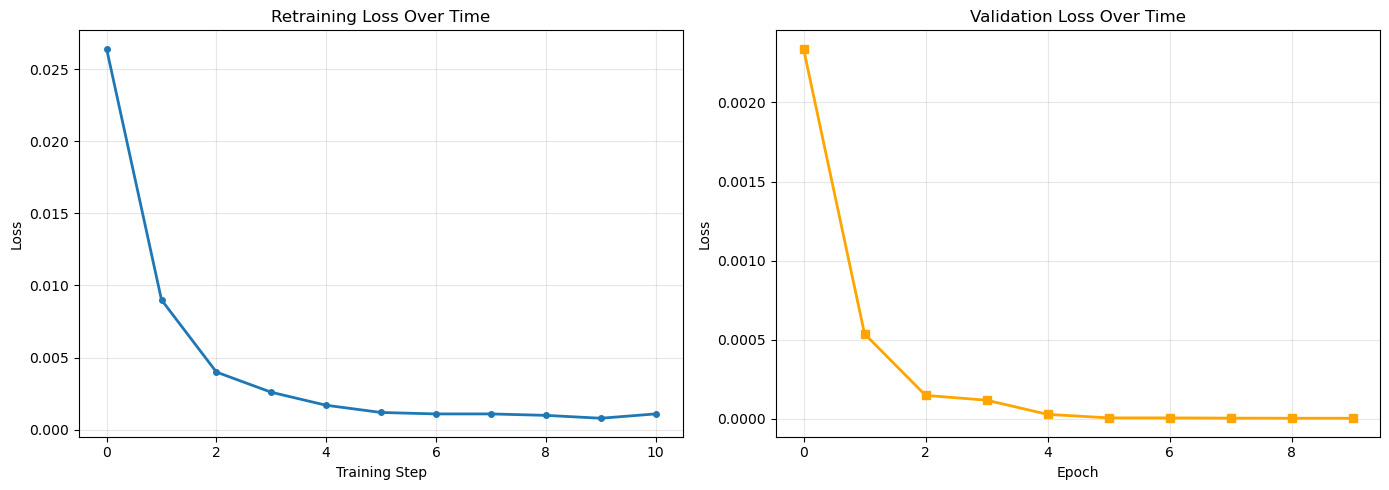


 Retraining complete!


In [12]:
# ==============================================================================
# CELL 9: Retrain Model with Enhanced Dataset
# ==============================================================================

print("="*80)
print("RETRAINING WITH ENHANCED DATASET")
print("="*80)

# Load existing trained model
print(f"\nLoading existing model from {output_dir_v0}...")
tokenizer_v1 = AutoTokenizer.from_pretrained(output_dir_v0)
model_v1 = AutoModelForSeq2SeqLM.from_pretrained(output_dir_v0)
model_v1.to(device)
print("Model loaded")

# Load enhanced dataset
print(f"\nLoading enhanced dataset from {CONFIG['enhanced_data_path']}...")
with open(CONFIG['enhanced_data_path'], 'r', encoding='utf-8') as f:
    enhanced_data = [json.loads(line) for line in f]

print(f"Enhanced samples: {len(enhanced_data)}")

# Shuffle and split
random.seed(42)
random.shuffle(enhanced_data)
train_size = int(CONFIG['train_split'] * len(enhanced_data))
val_size = int(CONFIG['val_split'] * len(enhanced_data))

enhanced_train = enhanced_data[:train_size]
enhanced_val = enhanced_data[train_size:train_size + val_size]
enhanced_test = enhanced_data[train_size + val_size:]

print(f"  Train: {len(enhanced_train)}")
print(f"  Val: {len(enhanced_val)}")
print(f"  Test: {len(enhanced_test)}")

# Prepare datasets
print("\nPreparing enhanced datasets...")
enhanced_train_dataset = create_dataset(enhanced_train)
enhanced_train_dataset = enhanced_train_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=enhanced_train_dataset.column_names
)

enhanced_val_dataset = create_dataset(enhanced_val)
enhanced_val_dataset = enhanced_val_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=enhanced_val_dataset.column_names
)

enhanced_test_dataset = create_dataset(enhanced_test)
enhanced_test_dataset = enhanced_test_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=enhanced_test_dataset.column_names
)

# Data collator
data_collator_v1 = DataCollatorForSeq2Seq(tokenizer_v1, model=model_v1)

# Training arguments
training_args_v1 = Seq2SeqTrainingArguments(
    output_dir=CONFIG['output_v_1'],
    num_train_epochs=CONFIG['retrain_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['retrain_lr'],  # Lower LR for fine-tuning
    weight_decay=0.01,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    # Ensure we actually see the loss changing
    logging_strategy="epoch",
    logging_steps=1,
    logging_first_step=True,
)

# Trainer
trainer_v1 = Seq2SeqTrainer(
    model=model_v1,
    args=training_args_v1,
    train_dataset=enhanced_train_dataset,
    eval_dataset=enhanced_val_dataset,
    tokenizer=tokenizer_v1,
    data_collator=data_collator_v1,
)

print("\n" + "="*80)
print("STARTING RETRAINING")
print("="*80)
print(f"Epochs: {CONFIG['retrain_epochs']}")
print(f"Learning rate: {CONFIG['retrain_lr']} (lower for fine-tuning)")
print("="*80)

# Train
train_result_v1 = trainer_v1.train()

# Save
print("\n" + "="*80)
print("SAVING ENHANCED MODEL")
print("="*80)
trainer_v1.save_model(CONFIG['output_v_1'])
tokenizer_v1.save_pretrained(CONFIG['output_v_1'])
print(f"Enhanced model saved to {CONFIG['output_v_1']}")

# Training summary
print("\n" + "="*80)
print("RETRAINING SUMMARY")
print("="*80)

logs_v1 = trainer_v1.state.log_history
train_losses_v1 = [x.get('loss') for x in logs_v1 if 'loss' in x]
eval_losses_v1 = [x.get('eval_loss') for x in logs_v1 if 'eval_loss' in x]

if train_losses_v1:
    print(f"Initial training loss: {train_losses_v1[0]:.4f}")
    print(f"Final training loss: {train_losses_v1[-1]:.4f}")
    print(f"Improvement: {train_losses_v1[0] - train_losses_v1[-1]:.4f}")

if eval_losses_v1:
    print(f"\nBest validation loss: {min(eval_losses_v1):.4f}")
    print(f"Final validation loss: {eval_losses_v1[-1]:.4f}")

# Plot
if len(train_losses_v1) > 0 and len(eval_losses_v1) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(train_losses_v1, marker='o', linewidth=2, markersize=4)
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Loss')
    ax1.set_title('Retraining Loss Over Time')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(eval_losses_v1, marker='s', linewidth=2, markersize=6, color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Validation Loss Over Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{CONFIG['output_v_1']}/retraining_curves.png', dpi=150, bbox_inches='tight')
    print(f"\n Training curves saved to {CONFIG['output_v_1']}/retraining_curves.png")
    plt.show()

print("\n Retraining complete!")

In [13]:
# ==============================================================================
# CELL 10: Evaluate Enhanced Model & Compare Performance
# ==============================================================================

# Only run this if enhancement was performed
if len(enhancement_data) > 0:
    print("="*80)
    print("EVALUATING ENHANCED MODEL")
    print("="*80)
    
    # Evaluate on enhanced test set
    test_results_v1 = trainer.evaluate(eval_dataset=enhanced_test_dataset)
    print(f"\nEnhanced Test Loss: {test_results_v1['eval_loss']:.4f}")
    
    # Comprehensive analysis on enhanced test set
    print("\n" + "="*80)
    print("COMPREHENSIVE ANALYSIS - ENHANCED MODEL")
    print("="*80)
    
    conn = sqlite3.connect(CONFIG['db_path'])
    results_v1 = []
    
    print(f"\nAnalyzing {len(enhanced_test_dataset)} test samples...")
    
    for idx in range(len(enhanced_test_dataset)):
        if idx % 50 == 0:
            print(f"  Progress: {idx}/{len(enhanced_test_dataset)}")
        
        sample = enhanced_test_dataset[idx]
        input_ids = torch.tensor([sample["input_ids"]]).to(device)
        
        with torch.no_grad():
            outputs = model_v1.generate(input_ids, max_length=MAX_TARGET_LENGTH)
        
        predicted_sql = decode_sql_from_model(
            tokenizer_v1.decode(outputs[0], skip_special_tokens=True)
        )
        actual_sql = decode_sql_from_model(
            tokenizer_v1.decode(sample["labels"], skip_special_tokens=True)
        )
        
        nl_question = enhanced_test[idx]["instruction"]
        
        # Categorize
        actual_categories, actual_complexity = categorize_query(actual_sql)
        is_exact_match = predicted_sql.strip() == actual_sql.strip()
        results_match = execute_and_compare(predicted_sql, actual_sql,CONFIG['db_path'])
        
        results_v1.append({
            'idx': idx,
            'question': nl_question,
            'predicted_sql': predicted_sql,
            'actual_sql': actual_sql,
            'actual_categories': actual_categories,
            'actual_complexity': actual_complexity,
            'is_exact_match': is_exact_match,
            'results_match': results_match
        })
    
    df_results_v1 = pd.DataFrame(results_v1)
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY - ENHANCED MODEL")
    print("="*80)
    
    total_v1 = len(df_results_v1)
    exact_matches_v1 = df_results_v1['is_exact_match'].sum()
    result_matches_v1 = df_results_v1['results_match'].sum()
    
    print(f"\nTotal test samples: {total_v1}")
    print(f"Exact SQL matches: {exact_matches_v1} ({100*exact_matches_v1/total_v1:.1f}%)")
    print(f"Semantic matches: {result_matches_v1} ({100*result_matches_v1/total_v1:.1f}%)")
    
    # Complexity breakdown
    print("\n" + "-"*80)
    print("ACCURACY BY COMPLEXITY")
    print("-"*80)
    
    for complexity in ['SIMPLE', 'MEDIUM', 'COMPLEX']:
        subset = df_results_v1[df_results_v1['actual_complexity'] == complexity]
        if len(subset) > 0:
            acc = subset['results_match'].sum()
            print(f"{complexity:12} : {acc}/{len(subset)} ({100*acc/len(subset):.1f}%)")
    
    # Category breakdown
    print("\n" + "-"*80)
    print("ACCURACY BY QUERY TYPE - ENHANCED MODEL")
    print("-"*80)
    
    all_categories_v1 = set()
    for cats in df_results_v1['actual_categories']:
        all_categories_v1.update(cats)
    
    category_stats_v1 = []
    for cat in sorted(all_categories_v1):
        subset = df_results_v1[df_results_v1['actual_categories'].apply(lambda x: cat in x)]
        if len(subset) > 0:
            correct = subset['results_match'].sum()
            total_cat = len(subset)
            accuracy = 100 * correct / total_cat
            category_stats_v1.append({
                'category': cat,
                'total': total_cat,
                'correct': correct,
                'accuracy': accuracy
            })
    
    df_cat_stats_v1 = pd.DataFrame(category_stats_v1).sort_values('accuracy')
    print(df_cat_stats_v1.to_string(index=False))
    
    # Compare with original model performance
    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON")
    print("="*80)
    
    # Load original performance from Cell 8
    if os.path.exists(f"{output_dir_v0}/category_stats.csv"):
        df_cat_stats_original = pd.read_csv(f"{output_dir_v0}/category_stats.csv")
        
        print("\nQuery Type              Original    Enhanced    Improvement")
        print("-" * 60)
        
        # Merge and compare all categories
        comparison = df_cat_stats_original.merge(
            df_cat_stats_v1[['category', 'accuracy']], 
            on='category', 
            how='outer',
            suffixes=('_v0', '_v1')
        )
        
        for _, row in comparison.iterrows():
            cat = row['category']
            orig_acc = row.get('accuracy_v0', 0)
            enh_acc = row.get('accuracy_v1', 0)
            
            if pd.notna(orig_acc) and pd.notna(enh_acc):
                improvement = enh_acc - orig_acc
                print(f"{cat:23} {orig_acc:6.1f}%     {enh_acc:6.1f}%     {improvement:+6.1f}%")
            elif pd.notna(enh_acc):
                print(f"{cat:23}    N/A       {enh_acc:6.1f}%         N/A")
        
        # Highlight weak categories that were targeted
        print("\n" + "-"*80)
        print("TARGETED WEAK CATEGORIES IMPROVEMENT")
        print("-"*80)
        
        for cat in weak_categories:
            orig_row = df_cat_stats_original[df_cat_stats_original['category'] == cat]
            enh_row = df_cat_stats_v1[df_cat_stats_v1['category'] == cat]
            
            if len(orig_row) > 0 and len(enh_row) > 0:
                orig_acc = orig_row.iloc[0]['accuracy']
                enh_acc = enh_row.iloc[0]['accuracy']
                improvement = enh_acc - orig_acc
                
                status = "✅" if improvement > 5 else "⚠️" if improvement > 0 else "❌"
                print(f"{status} {cat:20} : {orig_acc:5.1f}% → {enh_acc:5.1f}% ({improvement:+5.1f}%)")
    else:
        print("\nOriginal model performance not found for comparison.")
        print("Current enhanced model performance:")
        for _, row in df_cat_stats_v1.iterrows():
            print(f"  {row['category']}: {row['accuracy']:.1f}%")
    
    # Save results
    df_results_v1.to_csv(f"{CONFIG['output_v_1']}/test_results.csv", index=False)
    df_cat_stats_v1.to_csv(f"{CONFIG['output_v_1']}/category_stats.csv", index=False)
    
    # Save comparison
    if 'comparison' in locals():
        comparison.to_csv(f"{CONFIG['output_v_1']}/performance_comparison.csv", index=False)
    
    conn.close()
    
    print("\n Enhanced model evaluation complete!")
    print(f"Results saved to: {CONFIG['output_v_1']}/")
    
    # Summary
    print("\n" + "="*80)
    print("📈 FINAL SUMMARY")
    print("="*80)
    print(f"\nOriginal Model (v0): {overall_acc:.1f}% accuracy")
    print(f"Enhanced Model (v1): {100*result_matches_v1/total_v1:.1f}% accuracy")
    print(f"Overall Improvement: {100*result_matches_v1/total_v1 - overall_acc:+.1f}%")
    
    # Check if still weak
    new_weak = df_cat_stats_v1[df_cat_stats_v1['accuracy'] < CONFIG['weak_threshold']]['category'].tolist()
    if new_weak:
        print(f"\n Still weak categories: {new_weak}")
        print("Consider running another enhancement iteration (regenerate Cell 9-10)")
    else:
        print(f"\n All categories now above {CONFIG['weak_threshold']}% threshold!")

else:
    print(" No enhancement data was generated. Skipping enhanced model evaluation.")

EVALUATING ENHANCED MODEL



Enhanced Test Loss: 0.0577

COMPREHENSIVE ANALYSIS - ENHANCED MODEL

Analyzing 80 test samples...
  Progress: 0/80
  Progress: 50/80

SUMMARY - ENHANCED MODEL

Total test samples: 80
Exact SQL matches: 80 (100.0%)
Semantic matches: 76 (95.0%)

--------------------------------------------------------------------------------
ACCURACY BY COMPLEXITY
--------------------------------------------------------------------------------
SIMPLE       : 25/25 (100.0%)
MEDIUM       : 44/44 (100.0%)
COMPLEX      : 7/11 (63.6%)

--------------------------------------------------------------------------------
ACCURACY BY QUERY TYPE - ENHANCED MODEL
--------------------------------------------------------------------------------
        category  total  correct   accuracy
        GROUP_BY      2        0   0.000000
             SUM      2        0   0.000000
            JOIN      9        5  55.555556
             CTE     11        7  63.636364
             AVG      8        6  75.000000
GREATER_EQUAL_O